In [1]:
#imports
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
import jinja2

reading the dataset

In [2]:
def read_csv(file_path,has_header):
    """this function is used for taking the dataset from .csv file making a test train split
    and x, y split (has header is either True or False)"""

    #reading the .csv
    if has_header:
        df = pd.read_csv(file_path, header=0, delimiter=",")  # First row as header
        print(f"Dataset shape: {df.shape}")
        print(f"Column names: {list(df.columns)}")
    else:
        df = pd.read_csv(file_path, header=None, delimiter=",")  # No header row
        print(f"Dataset shape: {df.shape}")
    
    return df


selecting the dataset

dataset_name= "beans"
df = read_csv(dataset_name + "_kmeans.csv", True)
label_column = 16
number_of_sets = 4

dataset_name= "diabetes"
df = read_csv(dataset_name + "_kmeans.csv", True)
label_column = 8
number_of_sets = 3

dataset_name= "divorce"
df = read_csv(dataset_name + ".csv", True)
label_column = 54
number_of_sets = 14

dataset_name= "parkinsons"
df = read_csv(dataset_name + "_kmeans.csv", True)
df = df.drop(columns = 'name')
label_column = 16
number_of_sets = 6

In [3]:
dataset_name= "rice"
df = read_csv(dataset_name + "_binned_kmeans.csv", True)
label_column = 7
number_of_sets = 2

Dataset shape: (3810, 8)
Column names: ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent', 'Class']


dataset_name= "wdbc"
df = read_csv(dataset_name + "_binned_kmeans.csv", True)
df = df.drop(columns = 'ID')
label_column = 0
number_of_sets = 8

making string columns numeric

In [4]:
# Find all string/object columns automatically
string_columns = df.select_dtypes(include=['object']).columns
print(string_columns)
# Encode all string columns
for column in string_columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])

Index(['Class'], dtype='object')


mi for all features (graph)

In [5]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


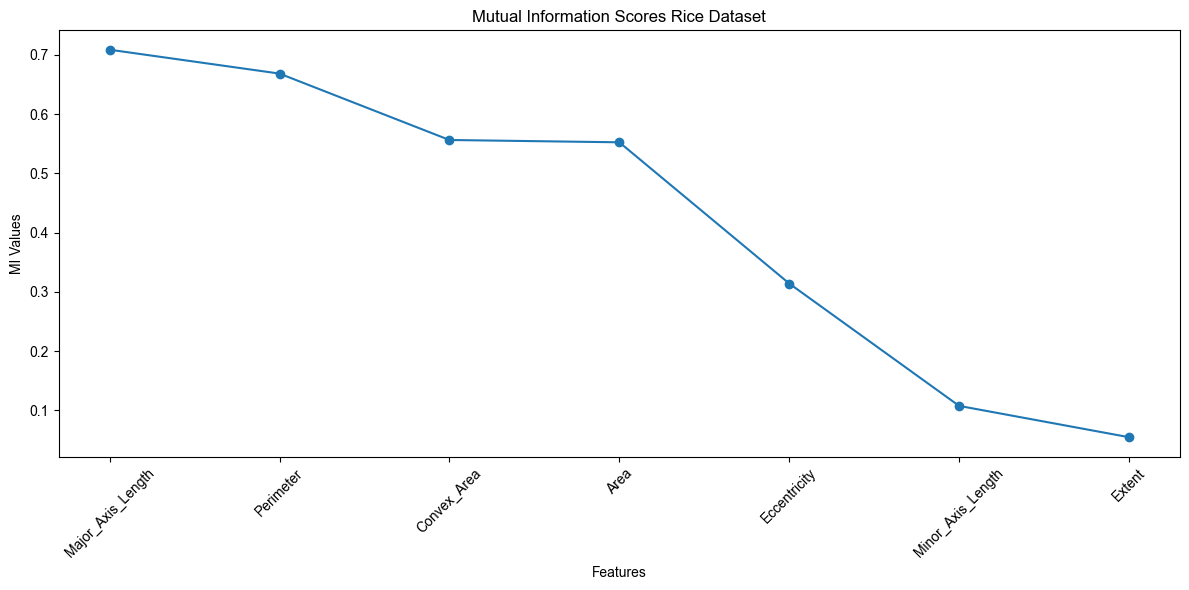

             Feature  MI_Score
2  Major_Axis_Length  0.708835
1          Perimeter  0.668529
5        Convex_Area  0.556463
0               Area  0.552562
4       Eccentricity  0.314257
3  Minor_Axis_Length  0.107695
6             Extent  0.054860


In [6]:
def mi_for_all(df_name = df, lc = label_column, title = 'complete dataset'):
    y = df_name.iloc[:, lc]
    #print(f'label is {y}')
    x = df_name.drop(df_name.columns[lc], axis=1)
    mi_scores = mutual_info_classif(x, y, discrete_features=True)
    mi_scores= mi_scores / np.log(2)



    #   ********   multiplied with -1 for the elbow method graphs
    #mi_scores= mi_scores * -1

    
    mi_df = pd.DataFrame({"Feature": x.columns, "MI_Score": mi_scores}).sort_values(by="MI_Score", ascending=False)




    # Create line plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(mi_df["Feature"], mi_df["MI_Score"], marker='o')
    ax.set_xlabel("Features")
    ax.set_ylabel("MI Values")
    ax.set_title(f"Mutual Information Scores {dataset_name.title()} Dataset")
    plt.style.use('seaborn-v0_8')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'mi {dataset_name} {title}.png', dpi=300, bbox_inches='tight')
    plt.show()


    return x,y,mi_df

x,y,mi_df= mi_for_all()
mi_df.to_latex(f'{dataset_name}_mi.tex', index=True, float_format='%.6f')
print(mi_df)


vertical split

In [7]:
# Target columns count (divide into 3 parts, take integer)
#total_columns = df.shape[1]
#target_columns_count = total_columns // 3
# Pick random feature columns from total number of columns from dataset x
#random.seed(42)
#random_cols = random.sample(range(x.shape[1]), target_columns_count - 1)
# Build target_set (label first, then random features)
#target_features = x.iloc[:, random_cols]
#target_set = pd.concat([y, target_features], axis=1)
#remaining_set = x.drop(x.columns[random_cols], axis=1)
#print("Target columns count:", target_columns_count)
#print("Selected feature indices:", random_cols)
#print(target_set.head(), "\n")
#print(remaining_set.head())

# Split the feature indices into groups
parts = np.array_split(np.arange(df.shape[1]), number_of_sets, axis=0)

# Get the first group of feature indices
#target_feature_indices = parts[0]

# Select the target features using column indices
#target_features = x.iloc[:, target_feature_indices]

# Create target set by concatenating y with target features
#target_set = pd.concat([y, target_features], axis=1)
print("Parts:")
for i, part in enumerate(parts):
    print(f"Part {i}: {part}")

target_set = None

# Find which part has the label column and get that part
for part in parts:
    if label_column in part:
        target_set = df.iloc[:, part]
        break

if target_set is not None:
    print(f"Target set shape: {target_set.shape}")
else:
    print(f"Label column {label_column} not found in any part")



#make label first column on target_set and the last column will be the lowst mi on target_set
label_col = df.columns[label_column]
col_data = target_set.pop(label_col)  # Remove the column
target_set.insert(0, label_col, col_data)  # Insert it at position 0


# Create remaining set by dropping the target feature columns
#remaining_set = x.drop(x.columns[target_feature_indices], axis=1)

#print("Selected feature indices:", target_feature_indices)

#print("Remaining set shape:", remaining_set.shape)
#print(remaining_set.head())


Parts:
Part 0: [0 1 2 3]
Part 1: [4 5 6 7]
Target set shape: (3810, 4)


mi on the set with label to find the target (lowest mi)

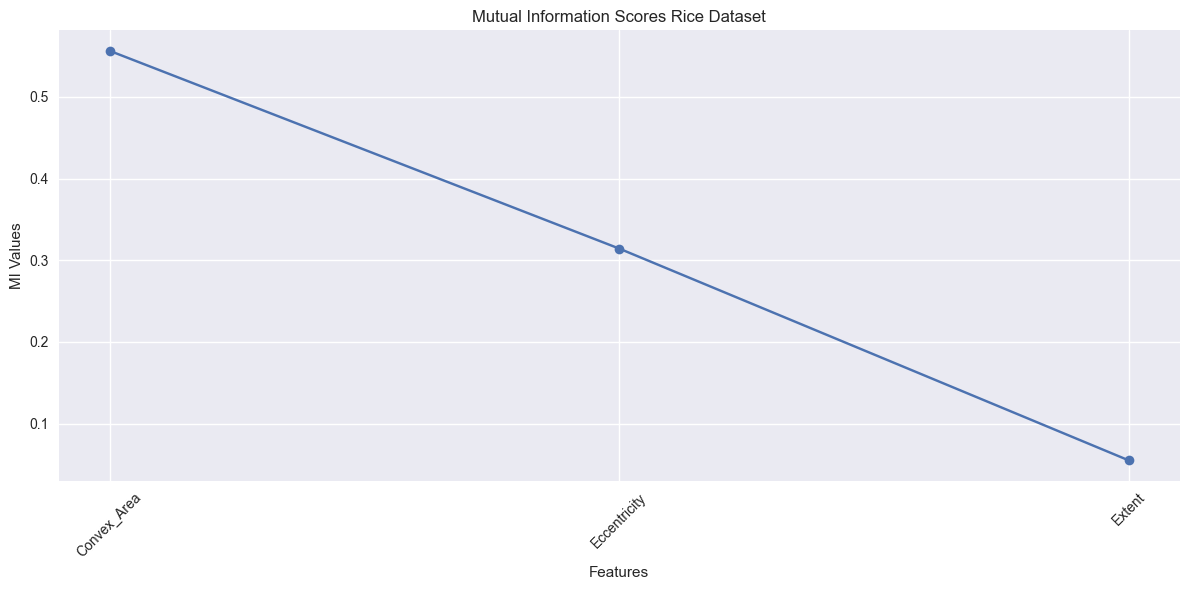

Column with lowest MI: Extent
lowest_mi_data:0        1.0
1        3.0
2        6.0
3        4.0
4        5.0
        ... 
3805     6.0
3806     6.0
3807     4.0
3808     5.0
3809    11.0
Name: Extent, Length: 3810, dtype: float64
Spearman correlations between 'Extent' and x:
             Feature  Spearman_Correlation
4       Eccentricity              0.229869
2  Major_Axis_Length              0.165003
1          Perimeter              0.152196
5        Convex_Area              0.085330
0               Area              0.080411
3  Minor_Axis_Length              0.063379


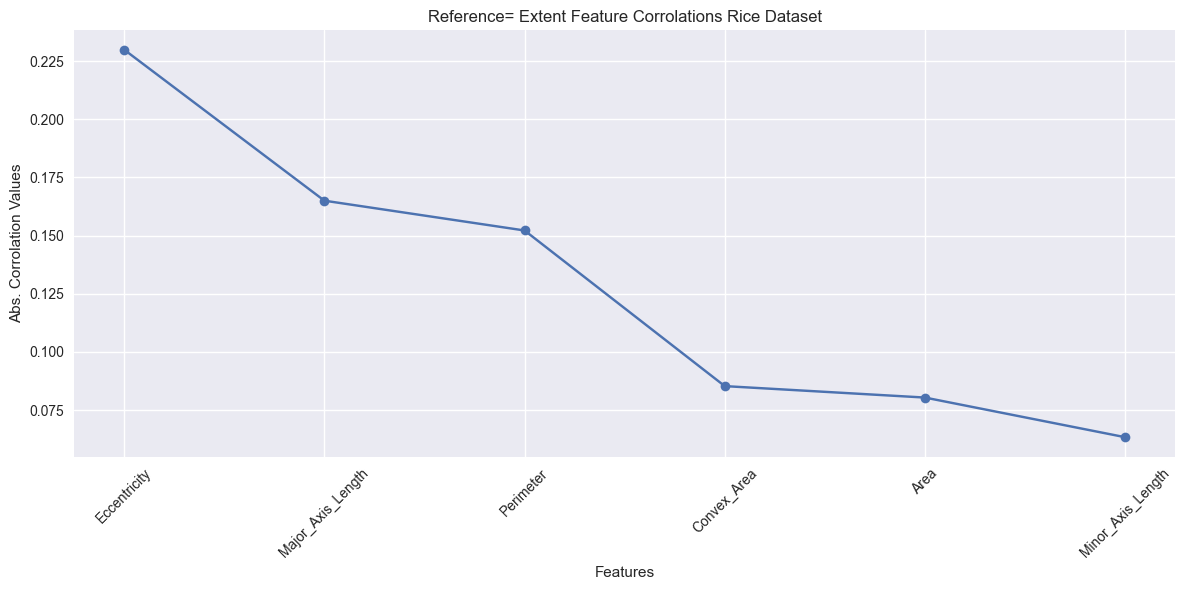

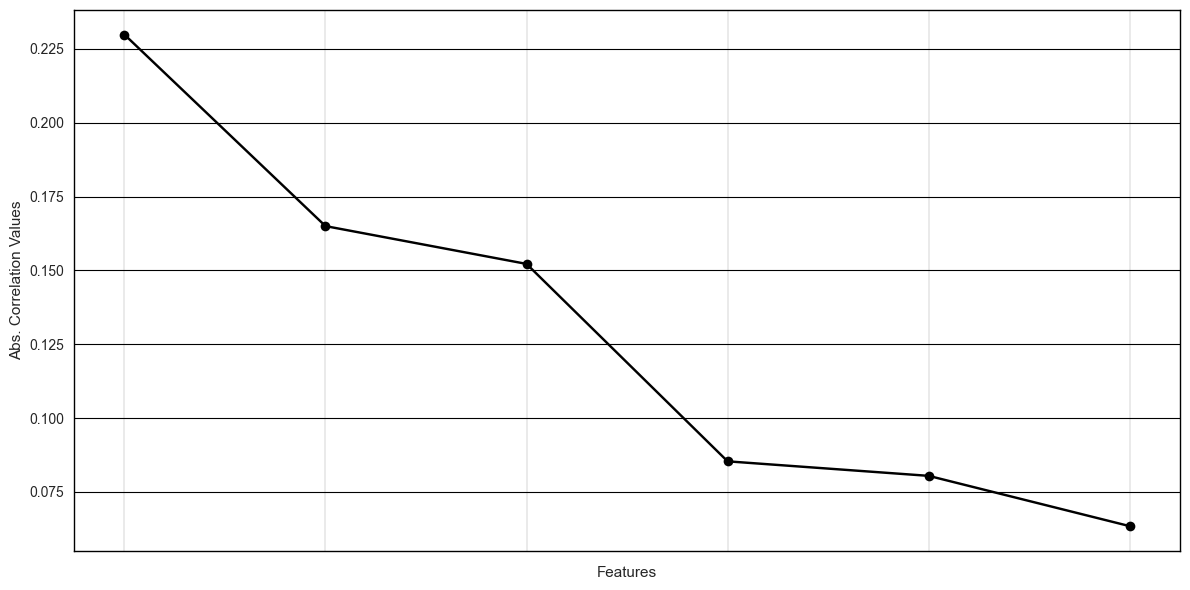

In [8]:
# Get MI scores and find lowest MI column
a,b,target_mi_df = mi_for_all(df_name=target_set, lc=0, title = 'in target set')

lowest_mi_column = target_mi_df.iloc[-1]['Feature']
print(f"Column with lowest MI: {lowest_mi_column}")

# Calculate Spearman correlations
lowest_mi_data = target_set[lowest_mi_column]
print(f"lowest_mi_data:{lowest_mi_data}")

#x_ranked = x.rank(method='average').astype(int)
#lowest_mi_ranked = lowest_mi_data.rank(method='average').astype(int)

correlations = x.corrwith(lowest_mi_data, method='spearman')

# Convert to DataFrame and sort
corr_df = pd.DataFrame({
    'Feature': correlations.index,
    'Spearman_Correlation': correlations.abs().values
}).sort_values('Spearman_Correlation', ascending=False)

# Remove the column that correlates with itself
corr_df = corr_df[corr_df['Feature'] != lowest_mi_column]


print(f"Spearman correlations between '{lowest_mi_column}' and x:")
print(corr_df)

# Create line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(corr_df["Feature"], corr_df["Spearman_Correlation"], marker='o')
ax.set_xlabel("Features")
ax.set_ylabel("Abs. Corrolation Values")
ax.set_title(f"Reference= {lowest_mi_column} Feature Corrolations {dataset_name.title()} Dataset")
plt.style.use('seaborn-v0_8')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{dataset_name} spearman correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Create 2nd line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(corr_df["Feature"], corr_df["Spearman_Correlation"], marker='o', color='black')
ax.set_xlabel("Features")
ax.set_ylabel("Abs. Correlation Values")
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
ax.grid(True, axis='y', color='black', linestyle='-', linewidth=0.8)
ax.grid(True, axis='x', color='gray', linestyle='-', linewidth=0.3, alpha=0.8)
ax.set_xticklabels([])
plt.tight_layout()
plt.savefig(f'{dataset_name} black_white_spearman correlation.png', dpi=300, bbox_inches='tight')
plt.show()

corr_df.to_latex(f'{dataset_name}_corr.tex', index=True, float_format='%.6f')

corr_df = corr_df.reset_index(drop=True)
corr_df['diffrence'] = corr_df['Spearman_Correlation'].diff(1)
corr_df['change'] = corr_df['diffrence'].diff(1) * -1
print(corr_df['change'])
print(np.argmax(corr_df['change']))

In [9]:
corr_df = corr_df.reset_index(drop=True)
corr_df['diffrence'] = corr_df['Spearman_Correlation'].diff(1)
corr_df['change'] = corr_df['diffrence'].diff(-1) 
print(corr_df)
print(np.argmax(corr_df['change']))


d = len(corr_df)

start_idx = int(np.ceil(0.10 * d))
end_idx   = int(np.floor(0.50 * d))

corr_df['is_candidate'] = False
corr_df.loc[start_idx:end_idx, 'is_candidate'] = True

epsilon = 5.0
delta_u = 1.0   # sensitivity of normalized rank


corr_df['em_score'] = 0.0
corr_df['em_probability'] = 0.0

candidates = corr_df[corr_df['is_candidate'] & corr_df['change'].notna()]


ranks = candidates['change'].rank(ascending=False, method='min')
n = len(ranks)
normalized_rank = (n - ranks) / (n - 1)
utilities = normalized_rank.values


scores = np.exp((epsilon * utilities) / (2 * delta_u))
probs = scores / scores.sum()

corr_df.loc[candidates.index, 'em_score'] = scores
corr_df.loc[candidates.index, 'em_probability'] = probs

np.random.seed(42)

selected_index = np.random.choice(
    candidates.index,
    p=corr_df.loc[candidates.index, 'em_probability']
)
print(selected_index)

corr_df_rounded = corr_df.round(3)
print(corr_df_rounded)

# Round numeric columns to 3 decimals
df_display = corr_df_rounded.copy()
numeric_cols = ['Spearman_Correlation', 'diffrence', 'change', 'em_score', 'em_probability']
df_display[numeric_cols] = df_display[numeric_cols].round(3)

# Optional: keep only the columns you want to show
columns_to_show = ['Feature'] + numeric_cols
df_display = df_display[columns_to_show]

# Convert to string for display (so it doesn’t add extra decimals)
df_display_str = df_display.astype(str)

# Display in Jupyter/console
print(df_display_str.to_string(index=False))



             Feature  Spearman_Correlation  diffrence    change
0       Eccentricity              0.229869        NaN       NaN
1  Major_Axis_Length              0.165003  -0.064866 -0.052058
2          Perimeter              0.152196  -0.012807  0.054059
3        Convex_Area              0.085330  -0.066866 -0.061948
4               Area              0.080411  -0.004919  0.012114
5  Minor_Axis_Length              0.063379  -0.017032       NaN
2
2
             Feature  Spearman_Correlation  diffrence  change  is_candidate  \
0       Eccentricity                 0.230        NaN     NaN         False   
1  Major_Axis_Length                 0.165     -0.065  -0.052          True   
2          Perimeter                 0.152     -0.013   0.054          True   
3        Convex_Area                 0.085     -0.067  -0.062          True   
4               Area                 0.080     -0.005   0.012         False   
5  Minor_Axis_Length                 0.063     -0.017     NaN         Fals

"""corr_df = corr_df.reset_index(drop=True)

print(corr_df)
corr_df['diffrence'] = corr_df['Spearman_Correlation'].diff(-1)
#corr_df['diffrence'] = corr_df['diffrence'] +1
print(corr_df)

corr_df["ratio"] = corr_df['diffrence'].shift(-1) / corr_df['diffrence']

#corr_df['ratio'] = corr_df['ratio'] -1
#corr_df['ratio'] = corr_df['ratio'] * 100

print(corr_df)
"""
df_excel = corr_df.copy()

# Flatten MultiIndex columns
if isinstance(df_excel.columns, pd.MultiIndex):
    df_excel.columns = ["_".join(map(str, c)) for c in df_excel.columns]

# Preserve index if meaningful
df_excel = df_excel.reset_index()

df_excel.to_excel(
    "diff.xlsx",
    sheet_name="beans",
    index=False,
    float_format="%.10f"
)


CHANGE İÇİN CONSTRAİNLİ EN YÜKSEĞİ EL baştan %10 sondan %50 sonra pozisyon bazlı Exponential Mechanishm uygula. DP sağlar.

valid_df = corr_df[corr_df["change"].notna()]
n = len(valid_df)
start_idx = int(n * 0.10)
end_idx = int(n * 0.50)

elbow_index = (valid_df.iloc[start_idx:end_idx]["change"].idxmin()) -1
print(elbow_index)

EM